# ePSproc/PEMtk dev - quick tests for density matrix code/plotting
22/08/21

See also:

- https://epsproc.readthedocs.io/en/latest/demos/ePSproc_demo_matE_plotting_Feb2020.html#Correlations
- https://phockett.github.io/tmo-dev/demos/LW06_correlations_test-demo_291220-dist.html
- Geometric codes


Methods:

- From Pandas DataFrame, [.corr() to run pair-wise methods](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) (correlation coeffs, inc. user-defined functions, keeps dim labels).
- Xarray [general tensor dot product](http://xarray.pydata.org/en/stable/generated/xarray.dot.html)?  (See test code somewhere...?)  (In geom codes sort-of do this, but with explicitly renamed coords.)
- Numpy [`outer()` for outer-product from vectors](https://numpy.org/devdocs/reference/generated/numpy.ufunc.outer.html) and higher-dim spaces (`.ufunc.outer()` version only!) (also [`tensordot()`](https://numpy.org/devdocs/reference/generated/numpy.tensordot.html) and [`einsum()`](https://numpy.org/devdocs/reference/generated/numpy.einsum.html) for more flexible ND operations - latter should be equivalent to Xarray functionality). (Note Numpy's version of [corrcoeff](https://numpy.org/devdocs/reference/generated/numpy.corrcoef.html) and cov are also possibly useful, but not as flexible as Pandas version.)


Also: prompting the long-delayed implementation of better plotting with Holoviews & more careful dim handling routines.


## Setup

In [ ]:
!hostname

In [ ]:
!conda env list

### Full import

In [ ]:
# Standard libs
import sys
import os
from pathlib import Path
import numpy as np
import xarray as xr

from datetime import datetime as dt
timeString = dt.now()


In [ ]:

# For module testing, include path to module here, otherwise use global installation
# local = True

# if local:
#     import sys
#     if sys.platform == "win32":
#         modPath = r'D:\code\github\ePSproc'  # Win test machine
#         winFlag = True
#     else:
#         modPath = r'~/github/ePSproc/'  # Linux test machine
#         winFlag = False

#     sys.path.append(modPath)


# Import
import epsproc as ep  

# Set data path
# Note this is set here from ep.__path__, but may not be correct in all cases - depends on where the Github repo is.
epDemoDataPath = Path(ep.__path__[0]).parent/'data'/'photoionization'



### Tidy import

In [ ]:
import sys
import os
from pathlib import Path
import numpy as np
# import epsproc as ep
import xarray as xr

import matplotlib.pyplot as plt

from datetime import datetime as dt
timeString = dt.now()

import epsproc as ep

# Multijob class dev code
from epsproc.classes.multiJob import ePSmultiJob

### Optional bits

In [ ]:
# Plotters
from epsproc.plot import hvPlotters
hvPlotters.setPlotters(width = 700, snsStyle='whitegrid')

In [ ]:
# # More optional plot settings
# import seaborn as sns

# sns.set(rc={'figure.figsize':(10,6)})  # Set figure size in inches
# sns.set_context("paper")
# sns.set_style("whitegrid")  # Set plot style
# sns.set_palette("Paired")   # Set colour mapping

# # Try direct fig type setting for PDF output figs
# from IPython.display import set_matplotlib_formats
# # set_matplotlib_formats('png', 'pdf')
# set_matplotlib_formats('svg', 'pdf')

In [ ]:
# To control display of warnings...
# https://stackoverflow.com/a/9031848
import warnings
warnings.filterwarnings('once')  # set 'once' or 'ignore'

# 16/08/21 ADDED TO util.env.isnotebook(), not yet tested.

## Load test data

### Class version

In [ ]:
# Class dev code
from epsproc.classes.multiJob import ePSmultiJob
from epsproc.classes.base import ePSbase

# Instantiate class object.
# Minimally this needs just the dataPath, if verbose = 1 is set then some useful output will also be printed.
data = ePSbase(epDemoDataPath, verbose = 1)

# ScanFiles() - this will look for data files on the path provided, and read from them.
data.scanFiles()

## Test single E point

Quick tests from lmPlot based [on previous stuff](https://epsproc.readthedocs.io/en/latest/demos/ePSproc_demo_matE_plotting_Feb2020.html#Correlations)

NOTE: this currently uses only abs/re/im values, use data.matEtoPD() to use full imag values.

In [ ]:
k = 'orb11'

data.lmPlot(keys = k, selDims = {'Type':'L','it':1})

# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(dataSet[0], selDims = {'Type':'L'}, sumDims = ['mu', 'Sym'],
#                                                plotDims = ('l','m'),
#                                                thresType='pc', thres = 0.01, figsize = (15,10))

In [ ]:
# Using Pandas .corr() - not quite right for single vector case (statistical correlation coeff)
# data.data[k]['daPlotpd'].T.corr()

# Custom function example, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
def histogram_intersection(a, b):

    v = np.minimum(a, b).sum().round(decimals=1)

    return v

# Try conjugate fn - note this is per row/col in data, so will sum over redundant dims (probably)
def conj_mult(a,b):
    v = a * np.conj(b)
    
    return v

# data.data[k]['daPlotpd'].T.corr(method=histogram_intersection)  # OK
data.data[k]['daPlotpd'].T.corr(method=conj_mult)  # OK (for single E)

In [ ]:
# Modified from https://epsproc.readthedocs.io/en/latest/demos/ePSproc_demo_matE_plotting_Feb2020.html#Correlations
# ep._sns_matrixMod.clustermap(data.data[k]['daPlotpd'].corr())

ep._sns_matrixMod.clustermap(data.data[k]['daPlotpd'].T.corr(method=conj_mult))


In [ ]:
# With sum over syms

k = 'orb11'

data.lmPlot(keys = k, selDims = {'Type':'L'}, sumDims = ['Sym'])


In [ ]:
data.data[k]['daPlotpd'].T.corr(method=conj_mult)  # OK (for single E)

In [ ]:
# Modified from https://epsproc.readthedocs.io/en/latest/demos/ePSproc_demo_matE_plotting_Feb2020.html#Correlations
# ep._sns_matrixMod.clustermap(data.data[k]['daPlotpd'].corr())

ep._sns_matrixMod.clustermap(data.data[k]['daPlotpd'].T.corr(method=conj_mult))

### Try HV plotting

See TMO-Dev for basics.

Seems like manual handling is still required for multi-index coords, 

- https://github.com/holoviz/hvplot/issues/351 (hvplot both Pandas and Xarray), 
- https://github.com/holoviz/holoviews/issues/2537 (holoviews Pandas)

although may be fixed in more recent versions.

Did some of this in tmo-dev work already...?

In [ ]:
# Plotters
from epsproc.plot import hvPlotters
hvPlotters.setPlotters(width = 700, snsStyle='whitegrid')

In [ ]:
# Quick default settings from tmo-dev, tmoDataBase.py init.

imgSize = 800
from holoviews import opts

opts.defaults(opts.HeatMap(width=imgSize, frame_width=imgSize, aspect='square', tools=['hover'], colorbar=True))

In [ ]:
# Set full complex dataset...

data.matEtoPD(keys = k, selDims = {'Type':'L'}, thres = 1e-2, squeeze=False)  # May need squeeze = False for singleton case
# data.matEtoPD(keys = k, xDim = 'it', selDims = {'Type':'L'})

In [ ]:
import holoviews as hv
import hvplot.pandas
hv.extension('bokeh')

# hv.HeatMap((labels, labels, testCC), ['x','y'], 'cc')  # TMO-dev version, directly from np array
# hv.HeatMap(data.data[k]['daPlotpd'].T.corr(method=conj_mult))  # Doesn't work directly from DataFrame

# Methods from https://stackoverflow.com/a/59804656
# df = data.data[k]['daPlotpd'].T.corr(method=conj_mult)  # Version from lmPlot (abs/re/im etc)
df = data.data[k]['matE'].attrs['pd'].T.corr(method=conj_mult)  # Full complex valued version

# df.hvplot.heatmap()  # This gives errors, but just to do with dim labels, 
                    # ValueError: Dimensions specified as a tuple must be a tuple consisting of the name and label not: (1, 1, -1, -1)
                    # Already solved this elsewhere...? Just need to convert multi-index to string label?
        
# df.reset_index().hvplot.heatmap()  # Throws different errors!

# (labels, labels, testCC), ['x','y'], 'cc'

# Conver labels to strings first...
labels = []
for item in df.index:
    labels.append(''.join(map(str, item)))
    
hv.HeatMap((labels, labels, df))  #.opts(width=800, height=800)  # OK with labels preset.
                                                                # NO ISSUE WITH COMPLEX DATATYPE? Automatic conversion to real?

# df.hvplot.heatmap(x=labels, y=labels)  # hvplot version still not OK.

In [ ]:
fdfsdfd

In [ ]:
# From https://github.com/holoviz/holoviews/issues/2537

# df.reset_index()
# hv.Whatever(long_with_cols, 
#             kdims=list(wide_form.index.names)[:-1])
list(df.index.names)  #[:-1]

In [ ]:
# From lmPlot code
daPlotpd = df
labels = []
for dim in daPlotpd.index.names:
            # 28/09/20: added .unique().sort_values(), should clean up legend a little bit?
            # EDIT: actually added only for legendList.append() stuff below.
            # Q: this should be OK, but may mess up multidim labels...?
            Labels = daPlotpd.index.get_level_values(dim)  # .unique().sort_values() #.astype('str')
            labels.append(Labels)
            
            # From tmo-dev correlations.py
#             labels.extend([f'{dim}-{n}' for n in range(0, dimArray.shape[1])]) 
            
labels

In [ ]:
labels = []
for item in daPlotpd.index:
    labels.append(''.join(map(str, item)))

# cList.append(pd.Series(Labels.astype('str'), index=daPlotpd.index).map(lut))
labels

### Xarray style functionality

In [ ]:
# From geometric code, e.g. afblmGeom.py lines 342 - 349
 
matE = data.data[k]['matE']
selDims = {'Type':'L'}
thres = 1e-1
thresDims = 'Eke'

# Threshold
matEthres = ep.matEleSelector(matE, thres = thres, inds = selDims, dims = thresDims, sq = True, drop = True)

# Matrix element pair-wise multiplication by (l,m,mu) dims
matEconj = matEthres.copy().conj()
# matEconj = matEconj.unstack().rename({'l':'lp','m':'mp','mu':'mup'})  # Full unstack
# matEmult = matEthres.unstack() * matEconj
matEconj = matEconj.unstack('LM').rename({'l':'lp','m':'mp','mu':'mup'})  # Unstack LM only.
matEmult = matEthres.unstack('LM') * matEconj
matEmult.attrs['dataType'] = 'multTest'

# Restack if desired
# matEmult = matEmult.stack({'LM':['l','m','mu'], 'LMp':['lp','mp','mup']})
matEmult = matEmult.stack({'LM':['l','m'], 'LMp':['lp','mp']})


# With multiindex...? Looks OK at a quick test, although different dims to .stack({'LM':['l','m','mu'], 'LMp':['lp','mp','mup']}) case 
#                    (presumably redundant terms created in that case... or missing terms in this case????????)
matEconj = matEthres.copy().conj()
matEconj2 = matEconj.rename({'LM':'LMp', 'mu':'mup'})  # Rename to ensure outer product
matEmult2 = matEthres * matEconj2

# General .dot version...
matEdot = xr.dot(matEthres, matEconj2, dims = [])  # Specify dims = [] to avoid summing over any shared dims.

In [ ]:
print(matEmult.shape)
print(matEmult.min())

print(matEmult2.shape)
print(matEmult2.min())

print(matEdot.shape)
print(matEdot.min())

In [ ]:
# matEmult.stack({'LM':['l','m','mu'], 'LMp':['lp','mp','mup']}).sum('Sym').real.plot()  # Plotting with multi-index throwing errors here (xr-13)
                                                                                        # Doesn't auto stack like Pandas version?
                                                                                        # Or no category plot?
matEmult.sum(['Sym','mu','mup'])  #.real.plot()

In [ ]:
matEmult.indexes

In [ ]:
# Test non-category version...
# da.assign_coords(dim_new=np.arange(len(da.dim_new)))  # Via assignment

# hvds = hv.Dataset(matEmult.sum(['Sym','mu','mup']).real)

# HV heatmap or image throwing errors - should handle multi-index, but might be some other issue here...?
# hv.HeatMap(hvds)
# hvds.to(hv.HeatMap)
# hvds.to(hv.Image, ['LM','LMp'])

# Test Pandas version
# df, _ = ep.multiDimXrToPD(matEmult.sum(['Sym','mu','mup']).real, colDims = {'LM':['l','m']})  # OK
df, _ = ep.multiDimXrToPD(matEmult.sum(['Sym','mu','mup']).imag, colDims = {'LM':['l','m']})  # OK
# df, _ = ep.multiDimXrToPD(matEmult.sum(['Sym','mu','mup']), colDims = {'LM':['l','m']})  # Definitely have complex values in this case

# Sum over Sym only (and restack mu)
# df, _ = ep.multiDimXrToPD(matEmult.sum(['Sym']).real, colDims = {'LM':['l','m','mu']})
# df, _ = ep.multiDimXrToPD(matEmult.sum(['Sym']).imag, colDims = {'LM':['l','m','mu']})


# hv.HeatMap(df)   # Nope - ValueError: Dimensions specified as a tuple must be a tuple consisting of the name and label not: (1, -1)

# Conver labels to strings first...
labels = []
for item in df.index:
    labels.append(''.join(map(str, item)))
    
hv.HeatMap((labels, labels, df))   # OK
# df.hvplot.heatmap(x='index', y='columns', colorbar=True)  # ValueError: Dimensions specified as a tuple must be a tuple consisting of the name and label not: (1, -1)

#### XR + HV BASICS OK above, but want to generalise to all dims & stack

See, e.g., 

- tmo-dev VMI.py for image stacking
- ePSproc utils
- ePSproc hvPlotters.py, currently implemented for XC plotting only. (Also in tmo-dev.utils with additional dim swapping.)

In [ ]:
# Basic dim checker already implemented
dimDict = ep.util.misc.checkDims(matEmult)  
dimDict

In [ ]:
# Check stacked dim mapping? NOW IMPLEMENTED ABOVE
# for item in dimDict['stacked']:
#     print(matEmult.indexes[item].names)

{k:matEmult.indexes[k].names for k in dimDict['stacked']}  # OK
# {k:matEmult.indexes[k].names for k in []}  # OK, just returns empty dict

In [ ]:
# **** No sum
# df, _ = ep.multiDimXrToPD(matEmult.real, colDims = {'LM':['l','m','mu']})  # This currently fails, need to specify for HV or group?
# df, _ = ep.multiDimXrToPD(matEmult.reset_index('Sym'), colDims = {'LM':['l','m','mu']})


# With groupby & stacking with HV - see 

# Conver labels to strings first...

for item in df.index.groupby('Sym'):
    labels = []
    labels.append(''.join(map(str, item)))
    
    hv.HeatMap((labels, labels, df))   # OK

In [ ]:
df, _ = ep.multiDimXrToPD(matEmult.reset_index('Sym'), colDims = {'LM':['l','m','mu']})
df

In [ ]:
df

In [ ]:
# Convert to labels?

# labels = []
# for item in matEplot.LM:
#     print(item)
#     labels.append(''.join(map(str, item.data)))


In [ ]:
# Teting resorting for HV plotting...

# matEplot = matEmult.sum('Sym').unstack().stack({'LM':['l','m','mu'], 'LMp':['lp','mp','mup']}).copy()
matEplot = matEmult.unstack().stack({'LM':['l','m','mu'], 'LMp':['lp','mp','mup']}).sum(['Total','Targ']).copy()

matEplot = matEplot.reset_index(['LM','LMp'])   # Drop existing (multiindex) coords

matEplot = matEplot.assign_coords({'LM':range(matEplot.LM.size), 'LMp':range(matEplot.LM.size)})  # Set new coords.
                                                                                                  # This array now works for basic hv.HeatMap
# matEplot.set_index({'LM':range(matEplot.LM.size)})

In [ ]:
import hvplot.xarray

# matEmult.stack({'LM':['l','m','mu'], 'LMp':['lp','mp','mup']}).sum('Sym').fillna(0).hvplot.heatmap()  # HV doesn't like multiindex?

# # Conver labels to strings first...
# labels = []
# for item in df.index:
#     labels.append(''.join(map(str, item)))
    
# hv.HeatMap((labels, labels, df))

# hv.HeatMap(matEmult.stack({'LM':['l','m','mu'], 'LMp':['lp','mp','mup']}).sum('Sym'), kdims=['LM','LMp'])   # Nope

# hvds = hv.Dataset(matEmult.stack({'LM':['l','m','mu'], 'LMp':['lp','mp','mup']}).sum('Sym'))

hvds = hv.Dataset(matEplot.squeeze().real)  #.fillna(0))
# hv.HeatMap(hvds, kdims = ['LMp','LM']) # OK for 2D case, get errors for ND? Should just work? #, vdims = ['Cont', 'Total'])

# Stacked cases are running, but not rendering...? Something with the data, or just temp glitch...?
                                                    # Looks like a temp or version issue, see additional tests below http://localhost:8888/lab/workspaces/pemtk#HV-tests-again
hvds.to(hv.Image, kdims=['LMp','LM'])  #.opts(colorbar=True)   
# hvds.to(hv.HeatMap, kdims=['LMp','LM'])

In [ ]:
hvds.name

In [ ]:
# Quick hvplot test...

# matEplot.real.hvplot.heatmap()   # Throws errors
matEplot.real.hvplot.image()   # OK (for 2D case at least)

## Function SCRATCH

In [ ]:
# Basic example works OK
import pandas as pd

df = pd.DataFrame({
    'colA': [10, 12, 14],
    'colB': [5, 3.0, 1.2],
    'colC': [1.2, 4.5, 2.3]},
    index=['group1', 'group2', 'group3'],
)

df.hvplot.heatmap()

In [ ]:
df

#### HV tests again

http://holoviews.org/getting_started/Gridded_Datasets.html

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
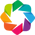

In [1]:
import holoviews as hv
import numpy as np

hv.extension('bokeh', 'matplotlib')

In [2]:
# data = np.load('../assets/twophoton.npz')
# calcium_array = data['Calcium']
# calcium_array.shape

dims = [50,111,62]
ds = hv.Dataset((np.arange(dims[0]), np.arange(dims[1]), np.arange(dims[2]), np.swapaxes(np.random.rand(*dims),0,2)),
                ['Time', 'x', 'y'], 'Fluorescence')

ds

:Dataset   [Time,x,y]   (Fluorescence)

In [3]:
type(ds.data), list(ds.data.keys())

(dict, ['Time', 'x', 'y', 'Fluorescence'])

In [4]:
ds.clone(datatype=['xarray']).data

<xarray.Dataset>
Dimensions:       (Time: 50, x: 111, y: 62)
Coordinates:
  * Time          (Time) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 103 104 105 106 107 108 109 110
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 ... 53 54 55 56 57 58 59 60 61
Data variables:
    Fluorescence  (y, x, Time) float64 0.1648 0.6083 0.1957 ... 0.5408 0.9153

In [5]:
ds.to(hv.Image, ['x', 'y']).hist()

:AdjointLayout
   :HoloMap   [Time]
      :Image   [x,y]   (Fluorescence)
   :HoloMap   [Time]
      :Histogram   [Fluorescence]   (Fluorescence_frequency)

In [ ]:
np.random.rand(*dims)
np.swapaxes(np.random.rand(*dims),0,2).shape

## Versions

In [6]:
import scooby
scooby.Report(additional=['epsproc', 'holoviews', 'hvplot', 'xarray', 'matplotlib', 'bokeh'])

* pyevtk not found, VTK export not available. 


--------------------------------------------------------------------------------
  Date: Wed Aug 25 12:15:54 2021 EDT

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

           epsproc : 1.3.1-dev
         holoviews : 1.12.6
            hvplot : 0.6.0
            xarray : 0.13.0
        matplotlib : 3.2.0
             bokeh : 1.4.0
             numpy : 1.18.1
             scipy : 1.3.1
           IPython : 7.13.0
            scooby : 0.5.5

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

In [ ]:
# Check current Git commit for local ePSproc version
from pathlib import Path
!git -C {Path(ep.__file__).parent} branch
!git -C {Path(ep.__file__).parent} log --format="%H" -n 1

In [ ]:
# Check current remote commits
!git ls-remote --heads git://github.com/phockett/ePSproc